In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from keras import Sequential
from keras.layers import Dense,MaxPooling2D,Conv2D,Flatten,Dropout
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
bs = 64
iz = 256

In [4]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "DataSet/Training",           
    shuffle = True,           
    seed = 16,               
    image_size = (iz, iz),  
    batch_size = bs           
)

Found 2870 files belonging to 4 classes.


In [5]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "DataSet/Testing",           
    shuffle = True,           
    seed = 16,               
    image_size = (iz, iz),  
    batch_size = bs           
)

Found 394 files belonging to 4 classes.


In [6]:
class_names = training_ds.class_names
print (class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [7]:
print(len(training_ds))
print(len(testing_ds))

45
7


In [8]:
for image_batch, lable_batch in training_ds.take(1):
    print(image_batch.shape)
    print(lable_batch.numpy())

(64, 256, 256, 3)
[3 0 0 1 2 0 3 2 1 3 1 2 1 3 3 1 2 2 1 2 1 0 3 3 3 3 0 1 0 3 1 2 2 3 0 3 3
 3 3 2 0 0 2 2 1 0 0 3 2 1 0 1 2 2 1 3 0 1 1 1 1 3 1 3]


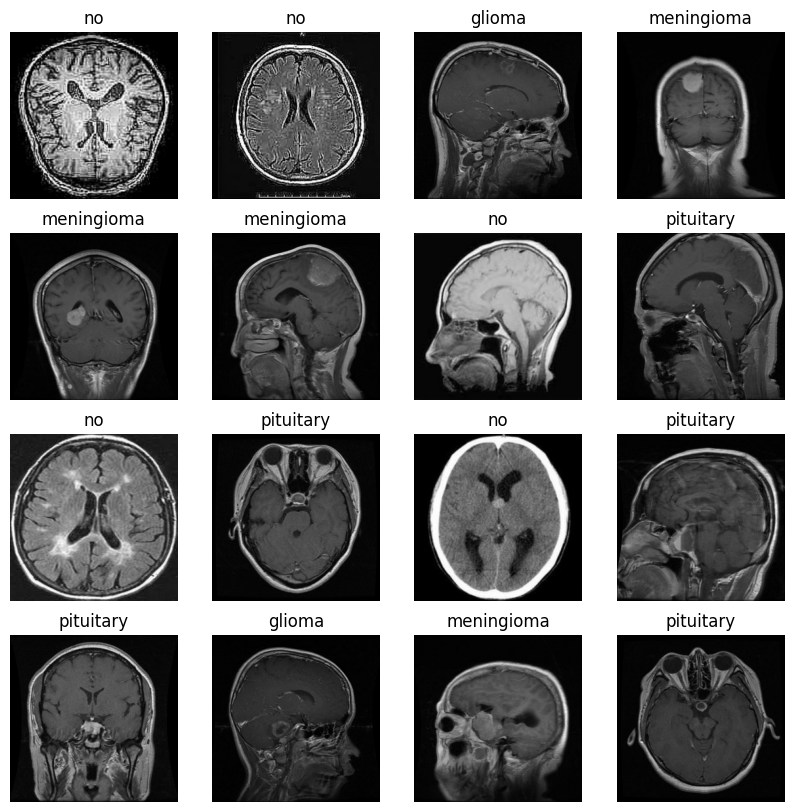

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, lable_batch in training_ds.take(1):  
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1) 
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[lable_batch[i]])
        plt.axis("off")

In [8]:
split = int(len(training_ds) * 0.2)
split

9

In [9]:
validation_ds = training_ds.take(split)

In [12]:
training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
testing_ds = testing_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(iz, iz),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

# data_augmentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomRotation(0.2),
#     layers.experimental.preprocessing.RandomContrast(0.4),
# ])

In [14]:
# training_ds = training_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

# plt.figure(figsize=(10, 10)) 
# for image_batch, lable_batch in training_ds.take(1):
#     for i in range(16):
#         ax = plt.subplot(5, 5, i + 1)
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.title(class_names[lable_batch[i]])
#         plt.axis("off")

In [15]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='tanh', input_shape=(bs,iz,iz,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='tanh'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='tanh'),
    layers.Dense(4, activation='softmax'),
])

model.build(input_shape=(bs,iz,iz,3))

In [16]:
# def norm(i,l):
#     i=tf.cast(i/255,tf.float32)
#     return i,l

# training_ds=training_ds.map(norm)
# testing_ds=testing_ds.map(norm)

In [17]:
# model=Sequential()
# model.add(Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=(256,256,3)))
# model.add(MaxPooling2D(2,2))
# model.add(Conv2D(64,kernel_size=(3,3),activation="relu"))
# model.add(MaxPooling2D(2,2))
# model.add(Conv2D(128,kernel_size=(3,3),activation="relu"))
# model.add(MaxPooling2D(2,2))
# model.add(Flatten())
# model.add(Dense(1024,activation="relu"))
# model.add(Dense(4,activation="softmax"))
# model.summary()

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)         

In [19]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
early = EarlyStopping(monitor = 'val_loss', patience=3)

In [21]:
history = model.fit(
    training_ds,
    batch_size=bs,
    validation_data=validation_ds,
    verbose=1,
    epochs=50,
    callbacks=early
)

Epoch 1/50


135/135 [==============================] - 48s 262ms/step - loss: 0.7152 - accuracy: 0.7062 - val_loss: 0.4091 - val_accuracy: 0.8397
Epoch 2/50
135/135 [==============================] - 25s 185ms/step - loss: 0.3136 - accuracy: 0.8830 - val_loss: 0.1908 - val_accuracy: 0.9381
Epoch 3/50
135/135 [==============================] - 21s 159ms/step - loss: 0.1806 - accuracy: 0.9389 - val_loss: 0.0936 - val_accuracy: 0.9786
Epoch 4/50
135/135 [==============================] - 21s 154ms/step - loss: 0.1029 - accuracy: 0.9675 - val_loss: 0.0693 - val_accuracy: 0.9792
Epoch 5/50
135/135 [==============================] - 21s 154ms/step - loss: 0.0513 - accuracy: 0.9861 - val_loss: 0.0551 - val_accuracy: 0.9838
Epoch 6/50
135/135 [==============================] - 21s 159ms/step - loss: 0.0283 - accuracy: 0.9945 - val_loss: 0.0407 - val_accuracy: 0.9855
Epoch 7/50
135/135 [==============================] - 21s 156ms/step - loss: 0.0289 - accuracy: 0.9921 - val_loss: 0.0176 - val_accuracy: 0.9

In [22]:
scores = model.evaluate(testing_ds)
scores

27/27 [==============================] - 2s 56ms/step - loss: 0.5581 - accuracy: 0.9179


[0.5580641627311707, 0.9178885817527771]

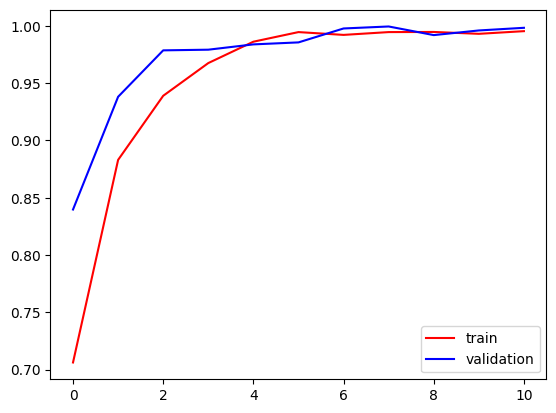

In [23]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

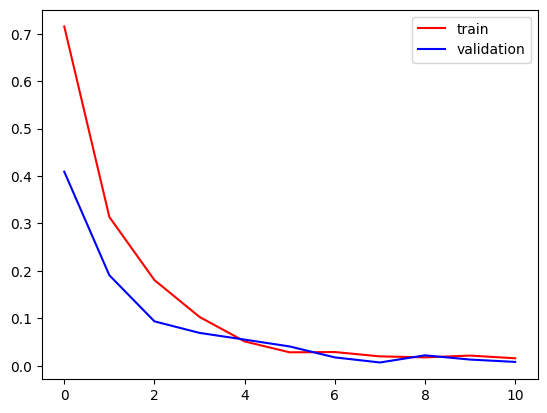

In [24]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

first image to predict
actual label: meningioma
predicted label: meningioma


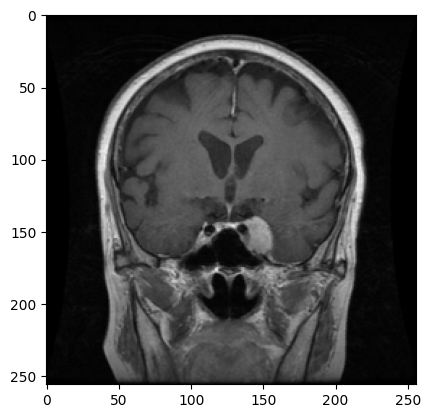

In [25]:
import numpy as np
for images_batch, labels_batch in testing_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch, verbose=0)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

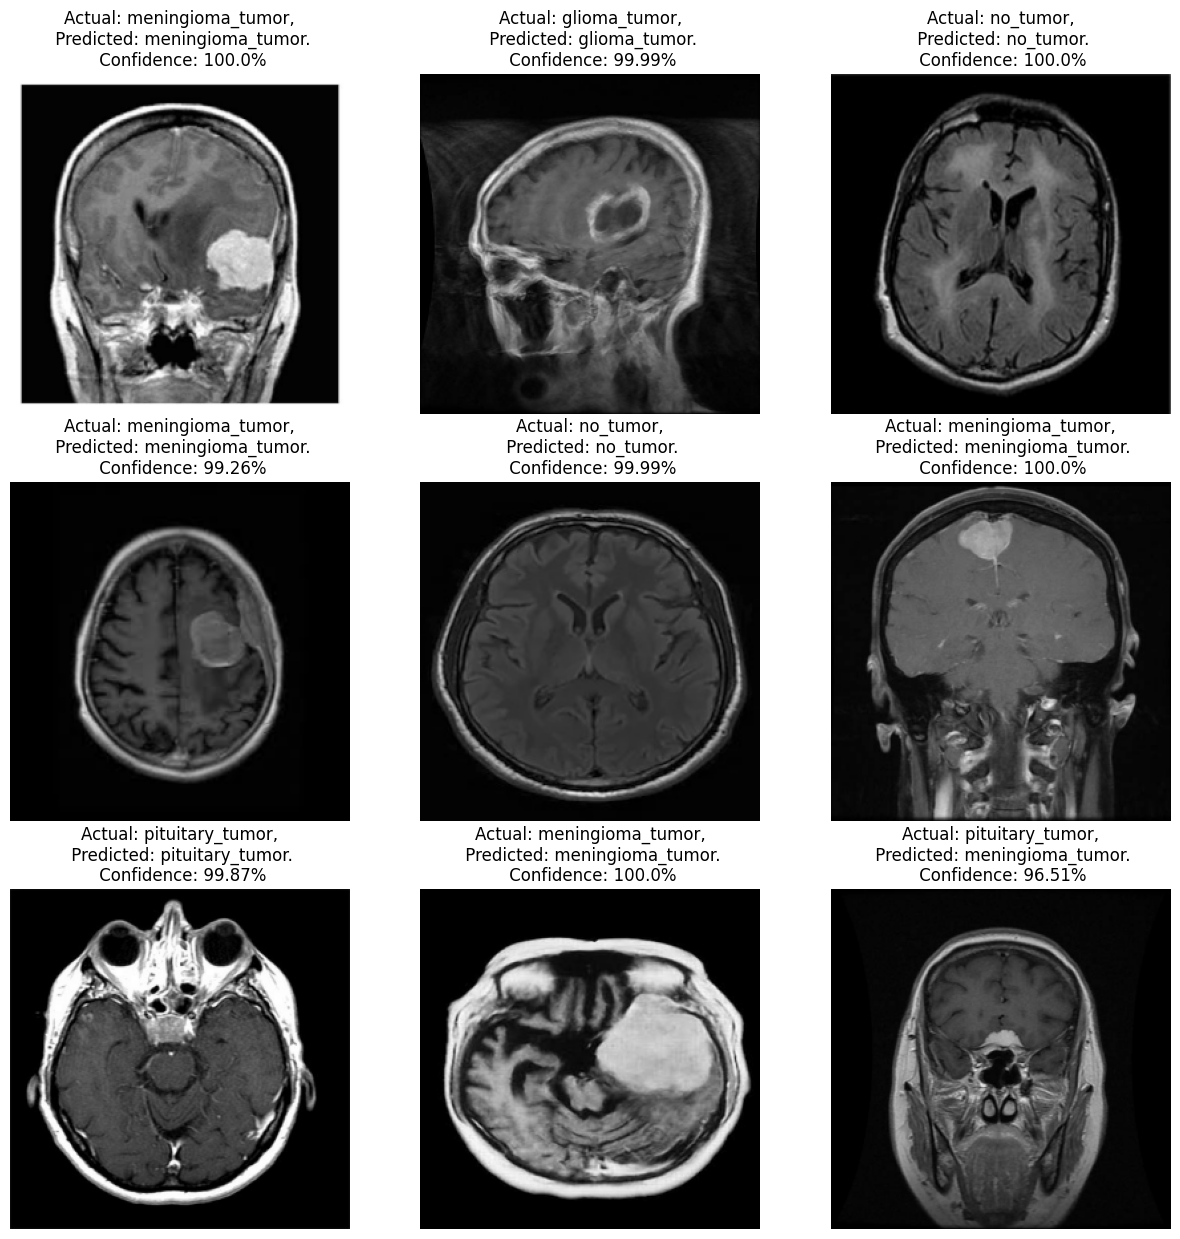

In [15]:
def predict(loaded_model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = loaded_model.predict(img_array, verbose=0)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in testing_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(loaded_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        

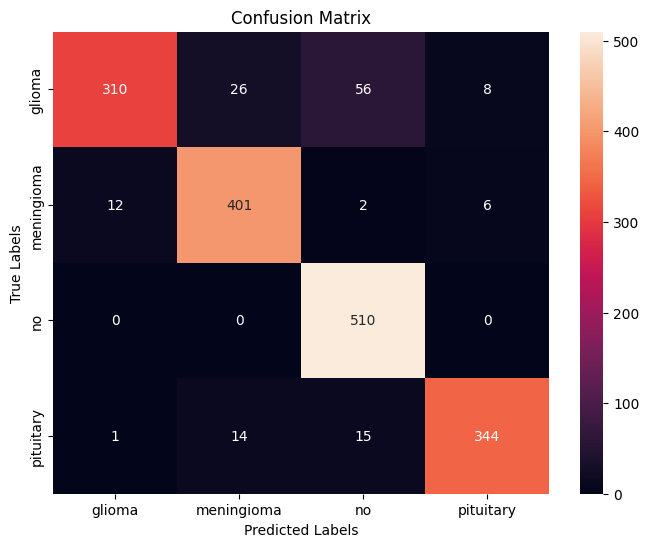

In [27]:
# Get the predicted labels for the test set
predicted_labels = []
true_labels = []

for images, labels in testing_ds:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [28]:
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = model.predict(images, verbose=0)
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))


# Calculate and print the classification report
report_test_ResNet50 = classification_report(y_true_test, y_pred_classes_test, target_names=class_names)

print(report_test_ResNet50)

              precision    recall  f1-score   support

      glioma       0.96      0.78      0.86       400
  meningioma       0.91      0.95      0.93       421
          no       0.87      1.00      0.93       510
   pituitary       0.96      0.92      0.94       374

    accuracy                           0.92      1705
   macro avg       0.93      0.91      0.92      1705
weighted avg       0.92      0.92      0.92      1705



In [3]:
# model.save(f"../Models/Version_1")
loaded_model = models.load_model(f"../Models/Version_1")